In [21]:
from src.config import filepaths
from src.utils import construct_sparse_adj_mat, load_json
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import entropy
from collections import defaultdict
from itertools import combinations

In [2]:
def axwise_entropy(mat: np.ndarray, axis: int):
    if axis != 0 and axis != 1:
        raise ValueError("Invalid axis. Only 2D arrays supported")
    elif axis == 0:
        axsum = mat.sum(axis=axis).reshape(1, -1)
    elif axis == 1:
        axsum = mat.sum(axis=axis).reshape(-1, 1)
    
    return np.where(axsum != 0, mat / axsum, 0)

def plot_cdf(ax, data, flip_axes=False, color='black', label=''):
    data = sorted(data)
    ycdf = np.arange(1, len(data) + 1) / len(data)

    if flip_axes:
        ax.plot(ycdf, data, color=color, label=label)
    else:
        ax.plot(data, ycdf, color=color, label=label)

In [3]:
smfp = filepaths['artifacts_sim_mats']
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'

adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
krs = load_json(filepaths['data_sprhea'] / f"{toc}.json")
rules = pd.read_csv(filepaths['data'] / "minimal1224_all_uniprot.tsv", sep='\t', )
rules.set_index('Name', inplace=True)

sim_metrics = [
    'bag_of_molecules_proteins_x_reactions',
    'rc_agg_r2_proteins_x_reactions',
    'rc_agg_r3_proteins_x_reactions',
    'rc_agg_r4_proteins_x_reactions',
    "rcmcs",
    "mcs",
    "tanimoto",
]

sim_mats = {name.removesuffix("_proteins_x_reactions"): np.load(smfp / f"{dataset}_{toc}_{name}.npy")
                for name in sim_metrics}

Constructing sprhea:v3_folded_pt_ns sparse adjacency matrix


In [91]:
sim_sel = 'rc_agg_r4'

diff = sim_mats[sim_sel] - adj
diff = np.array(diff)

crossovers = np.argwhere(diff > 0.5)
crossovers = np.vstack(sorted(crossovers, key=lambda x: diff[*x], reverse=True))
most_diffs = diff[crossovers[:, 0], crossovers[:, 1]].reshape(-1,)
crossover_ids = [(idx_sample[i], idx_feature[j]) for i, j in crossovers]

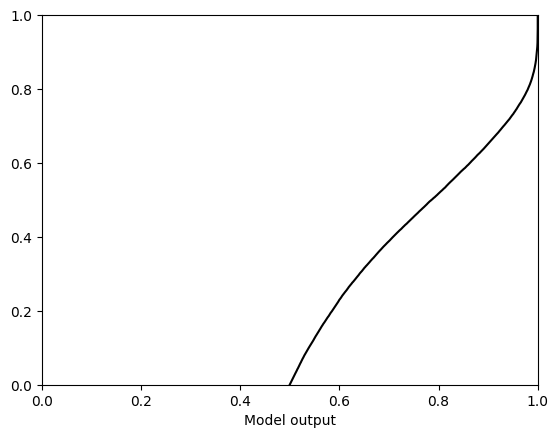

In [92]:
fig, ax = plt.subplots()
plot_cdf(ax, most_diffs)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_xlabel("Model output")
plt.show()

In [93]:
# Keys are adj mat idx of (prot, novel rxn, known rxns)
novel_triples = defaultdict(lambda : defaultdict(lambda : defaultdict(float)))
novel_pair_sim_stats = {}
for p, r in crossovers:
    other_rs = adj[p, :].nonzero()[1]
    other_sims = sim_mats['rcmcs'][r, other_rs]
    novel_pair_sim_stats[(p, r)] = (other_sims.mean(), other_sims.std())
    for o, s in zip(other_rs, other_sims):
        novel_triples[p][r][o] = s

srt_novel_pairs = sorted(novel_pair_sim_stats.keys(), key=lambda x : novel_pair_sim_stats[x][0], reverse=True)

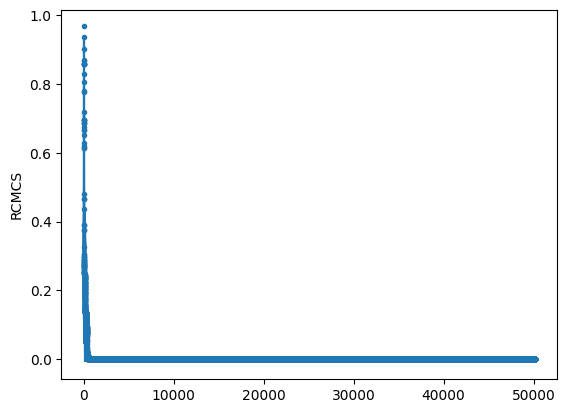

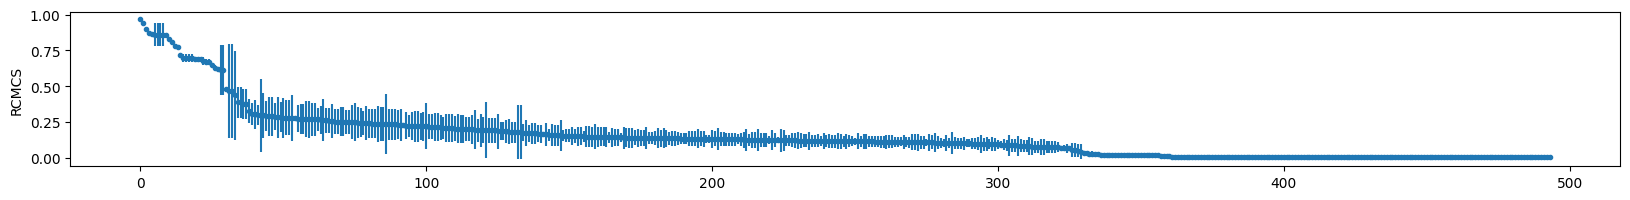

In [107]:
x = np.arange(len(srt_novel_pairs))
means, stds = zip(*[novel_pair_sim_stats[key] for key in srt_novel_pairs])
nz_means, nz_stds = zip(*[(m, s) for m, s in zip(means, stds) if m > 0])
nz_x = np.arange(len(nz_means))


fig, ax = plt.subplots()
ax.errorbar(x=x, y=means, yerr=stds, fmt='.' )
ax.set_ylabel("RCMCS")
plt.show()

fig, ax = plt.subplots(figsize=(20, 2))
ax.errorbar(x=nz_x, y=nz_means, yerr=nz_stds, fmt='.' )
ax.set_ylabel("RCMCS")
plt.show()

In [95]:
# Benchmark within-protein rcmcs between known reactions

protein_rcmcs_benchmark = {}
for p in range(adj.shape[0]):
    known_rs = adj[p, :].nonzero()[1]
    if len(known_rs) > 1:
        i, j = zip(*combinations(known_rs, 2))
        sims = sim_mats['rcmcs'][i, j]
        protein_rcmcs_benchmark[p] = (sims.mean(), sims.std())

srt_rcmcs_benchmark = sorted(protein_rcmcs_benchmark.keys(), key=lambda x : protein_rcmcs_benchmark[x][0], reverse=True)

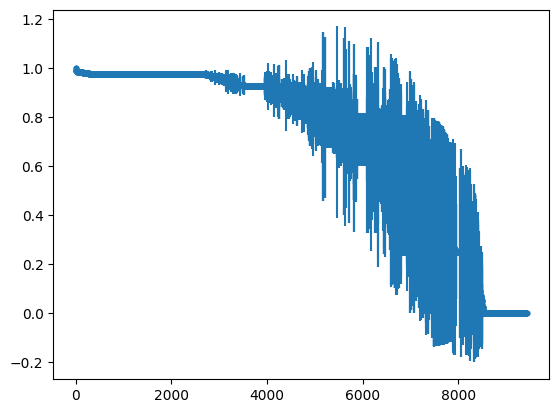

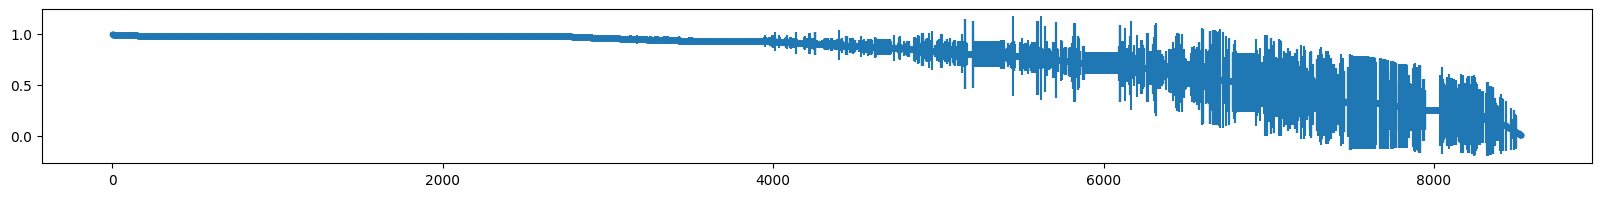

In [96]:
x = np.arange(len(srt_rcmcs_benchmark))
means, stds = zip(*[protein_rcmcs_benchmark[key] for key in srt_rcmcs_benchmark])
nz_means, nz_stds = zip(*[(m, s) for m, s in zip(means, stds) if m > 0])
nz_x = np.arange(len(nz_means))


fig, ax = plt.subplots()
ax.errorbar(x=x, y=means, yerr=stds, fmt='.' )
plt.show()

fig, ax = plt.subplots(figsize=(20, 2))
ax.errorbar(x=nz_x, y=nz_means, yerr=nz_stds, fmt='.' )
plt.show()

In [104]:
cf = adj @ (sim_mats['rcmcs'] / sim_mats['rcmcs'].sum(axis=0).reshape(1, -1))
cf /= cf.sum(axis=1).reshape(-1, 1)
cf[0, :]

array([0.11540343, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])